# Python notebook to plot apical region response to stimulation.
Assumes folder directory structure:
<pre><code>  IMAGING
    image_stacks
    notebooks
    results
</code></pre>
Execute the code sequentially, one block at a time, using &lt;shift-return&gt;.

In [1]:
import csv
import datetime
import glob
import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl
import numpy as np
import os
from skimage import exposure
from skimage import io
from skimage.morphology import binary_erosion, binary_dilation
from skimage.morphology import remove_small_objects
from skimage.measure import label, regionprops
from skimage.util import img_as_float32

#### Select image stack file(s).
Select multiple images using command-click. \
Only select multiple stacks that have the same pixel and depth dimensions!

In [2]:
%matplotlib widget

# global variables
image_files = {}    # image stack name(s)

# create image file(s) widget
image_files = sorted([f.split('/')[-1] for f in glob.glob("../image_stacks/*.tif", recursive=False)], key=str.casefold)
image_widget = widgets.SelectMultiple(options=image_files, description='Image stack(s)', 
                            disabled=False, layout={'width':'400px'}, style={'description_width':'150px'})

# display and respond to the widgets
def f(w1):
  global image_files
  image_files = image_widget.value
display(widgets.interactive(f, w1=image_widget))


interactive(children=(SelectMultiple(description='Image stack(s)', layout=Layout(width='400px'), options=('les…

#### Enter short descriptive image stack labels.
Note: Enter alpha-numeric values only.


In [3]:
%matplotlib widget

# global variables
image_tags = []         # list of image file tag labels
roi_idx = 0             # image file index to use to use for generating roi's

# create image tag widget(s)
image_tag_widgets = []
m = 6                   # a static number of widgets to display
n = len(image_files)    # the number of image stack files selected
for i in range(m):
  if i >= n:
    d = ' '
  else:
    d = image_files[i]
  image_tag_widgets.append(widgets.Text(value='', placeholder='enter a label', description=d,
                    disabled=(i>=n), layout={'width':'300px'}, style={'description_width':'200px'}))
# display and respond to the widgets
def f(w1,w2,w3,w4,w5,w6):
  global image_tags, roi_idx
  image_tags = [(w.value,idx) for idx,w in enumerate(image_tag_widgets)]
  for t in image_tags[:n]:
    print('Is label "' + t[0] + '" alpha-numeric?', t[0].isalnum())
display(widgets.interactive(f, w1=image_tag_widgets[0],
                               w2=image_tag_widgets[1],
                               w3=image_tag_widgets[2],
                               w4=image_tag_widgets[3],
                               w5=image_tag_widgets[4],
                               w6=image_tag_widgets[5]))


interactive(children=(Text(value='', description='Mistgcamp-3.tif', layout=Layout(width='300px'), placeholder=…

#### Set display and calculation parameters.
Note: An LUT color reference can be found at:
https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html

In [16]:
%matplotlib widget

# global variables
roi_idx = 0               # index of image/label use for generating roi's
lut = 'coolwarm'          # the stack animation color lookup table
stim_start = 100          # stimulation start frame
stim_done = 250           # stimulation end frame (including decay?)
image_bits = 10           # bits per pixel (can be found in the oir meta data)
image_fps = 10            # image data frames per second
small_object = 16         # small object size to cull
dilations = 2             # number of dilations to apply
roi_quantile = 0.98       # roi threashold (0.98)
method = 'average'        # stimulation detection calculation method

s = {'description_width':'200px'} # a default widget style

# create roi tag widget
roi_tag_widget = widgets.Dropdown(options=image_tags[0:len(image_files)], 
                 value=roi_idx, description='Image stack for ROI creation', 
                 disabled=False, layout={'width':'300px'}, style=s)

# create lut widget
lut_widget = widgets.Dropdown(options=plt.colormaps(), value=lut, description='Image stack LUT', 
             disabled=False, layout={'width':'350px'}, style=s)

# create method widget
method_widget = widgets.Dropdown(options=['average', 'std'], value=method, description='Calculation method',
                disabled=False, layout={'width':'300px'}, style=s)

# create numeric input widgets
stim_start_widget = widgets.BoundedIntText(value=stim_start, min=0, max=1000, step=1,
                    description='Stimulation start frame', disabled=False, layout={'width':'270px'}, style=s)
stim_done_widget = widgets.BoundedIntText(value=stim_done, min=0, max=1000, step=1,
                    description='Stimulation done frame', disabled=False, layout={'width':'270px'}, style=s)
image_bits_widget = widgets.BoundedIntText(value=image_bits, min=8, max=16, step=1,
                    description='Image data bits', disabled=False, layout={'width':'270px'}, style=s)
image_fps_widget = widgets.BoundedIntText(value=image_fps, min=1, max=40, step=1,
                    description='Image stack frames per second', disabled=False, layout={'width':'270px'}, style=s)
small_object_widget = widgets.BoundedIntText(value=small_object, min=1, max=100, step=1,
                    description='Small region cull size', disabled=False, layout={'width':'270px'}, style=s)
dilations_widget = widgets.BoundedIntText(value=dilations, min=0, max=10, step=1,
                    description='Number of dilations', disabled=False, layout={'width':'270px'}, style=s)
roi_quantile_widget = widgets.BoundedFloatText(value=roi_quantile, min=0.8, max=0.99, step=0.01,
                    description='ROI threashold quantile', disabled=False, layout={'width':'270px'}, style=s)

# display and respond to the widgets
def f(w10,w1,w2,w3,w4,w5,w6,w7,w8,w9):
  global lut, stim_start, stim_done, image_bits, image_fps, small_object, dilations
  global roi_quantile, method, roi_idx
  lut = lut_widget.value
  stim_start = stim_start_widget.value
  stim_done = stim_done_widget.value
  image_bits = image_bits_widget.value
  image_fps = image_fps_widget.value
  small_object = small_object_widget.value
  dilations = dilations_widget.value
  roi_quantile = roi_quantile_widget.value
  method = method_widget.value
  roi_idx = roi_tag_widget.value
display(widgets.interactive(f, 
    w10=roi_tag_widget, w1=lut_widget, w2=stim_start_widget, w3=stim_done_widget, w5=image_bits_widget,
    w4=image_fps_widget, w6=small_object_widget, w7=dilations_widget, w8=method_widget, 
    w9=roi_quantile_widget))



interactive(children=(Dropdown(description='Image stack for ROI creation', layout=Layout(width='300px'), optio…

#### Create a new time-stamped results directory.

In [17]:
# create time-stamped results directory
if not os.path.exists("../results"):
  os.mkdir("../results")
resultsdir = str(datetime.datetime.now())[:-7]
resultsdir = resultsdir.replace('-', '').replace(' ', '-').replace(':','')
resultsdir = "../results/" + resultsdir
os.mkdir(resultsdir)

# write out the image stack file names used
f = open(resultsdir + '/' + "image_stacks.txt", "w")
for v in image_files:
  f.write(v+'\n')
f.close()

# write out the labels used
f = open(resultsdir + '/' + "labels.txt", "w")
for i in range(len(image_files)):
  f.write(image_tags[i][0]+'\n')
f.close()

#### Get the image stack for ROI creation.


In [18]:
# get the image stack for roi's
A0 = io.imread("../image_stacks/" + image_files[roi_idx])
A0 = np.float32(A0/(2.0**image_bits))

# average out y-direction aliasing over every other line
for n in range(A0.shape[0] - 1): # moving average over every two lines
  A0[n] = (A0[n] + A0[n+1]) / 2.0


#### Unstimulated average (or standard deviation) over time.


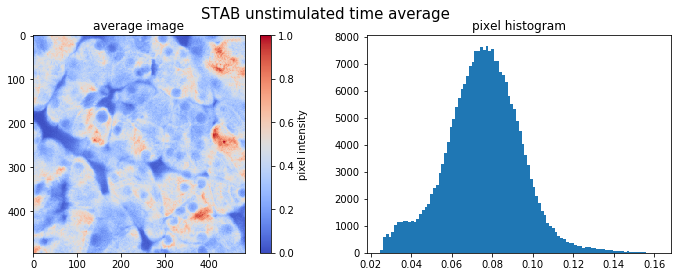

In [25]:
%matplotlib inline

# unstimulated average or std over time
A = np.concatenate((A0[:stim_start-1,:,:], A0[stim_done:,:,:])) # unstimulated only
if method == "std":
  M = np.std(A, axis=0)
else:
  M = np.mean(A, axis=0)

# plot image
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = [12, 4])
fig.suptitle(image_tags[roi_idx][0] + " unstimulated time " + method , fontsize=15)

cs = ax[0].imshow(M, norm=None, cmap=lut) # image
ax[0].set_title(method + " image")
if method == "std":
  fig.colorbar(cs, ax=ax[0])
elif method == "average":
  norm = mpl.colors.Normalize(vmin=0, vmax=1)
  v = mpl.cm.ScalarMappable(norm=norm, cmap=lut)
  fig.colorbar(v, ax=ax[0], orientation='vertical', label='pixel intensity')

ax[1].hist(M.flatten(), bins=100) # histogram
ax[1].set_title("pixel histogram")
fig.savefig(resultsdir + "/" + image_tags[roi_idx][0] + "-unstimulated_time_" + method + ".pdf")
plt.show()


#### Stimulated average (or standard deviation) over time.


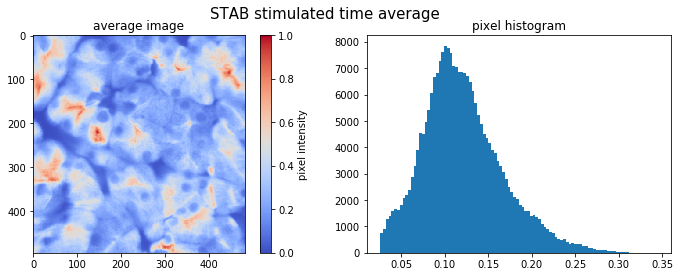

In [26]:
%matplotlib inline

# stimulated average or std over time
A = A0[stim_start-1:stim_done-1,:,:] # stimulated only
if method == "std":
  N = np.std(A, axis=0)
elif method == "average":
  N = np.mean(A, axis=0)

# plot image
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = [12, 4])
fig.suptitle(image_tags[roi_idx][0] + " stimulated time " + method, fontsize=15)

cs = ax[0].imshow(N, norm=None, cmap=lut) # image
ax[0].set_title(method + " image")
if method == "std":
  fig.colorbar(cs, ax=ax[0])
elif method == "average":
  norm = mpl.colors.Normalize(vmin=0, vmax=1)
  v = mpl.cm.ScalarMappable(norm=norm, cmap=lut)
  fig.colorbar(v, ax=ax[0], orientation='vertical', label='pixel intensity')

ax[1].hist(N.flatten(), bins=100) # histogram
ax[1].set_title("pixel histogram")
fig.savefig(resultsdir + "/" + image_tags[roi_idx][0] + "-stimulated_time_" + method + ".pdf")
plt.show()


#### Stimulated minus unstimulated average (or standard deviation) over time.


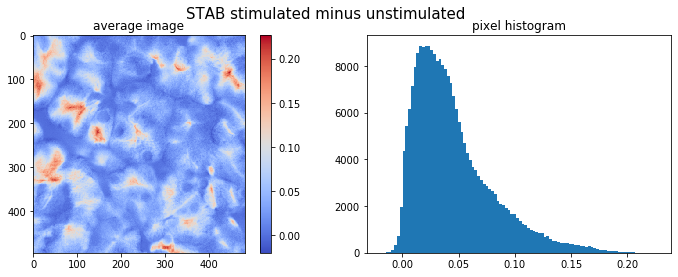

In [27]:
%matplotlib inline

# difference: stimulated - unstimulated
O = N - M

# plot image
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = [12, 4])
fig.suptitle(image_tags[roi_idx][0] + " stimulated minus unstimulated", fontsize=15)

cs = ax[0].imshow(O, norm=None, cmap=lut) # image
fig.colorbar(cs, ax=ax[0])
ax[0].set_title(method + " image")

ax[1].hist(O.flatten(), bins=100) # histogram
ax[1].set_title("pixel histogram")
fig.savefig(resultsdir + "/" + image_tags[roi_idx][0] + "-stimulated_minus_unstimulated.pdf")
plt.show()


#### Create apical region-of-interest mask.


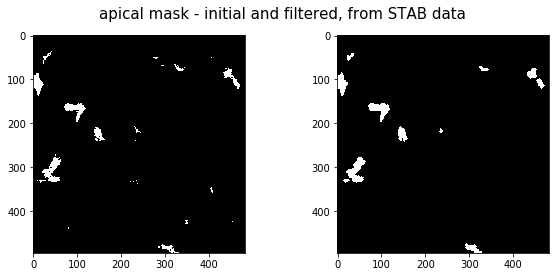

stimulation: STAB
number of apical regions identified:  11
apical ROI labels:  [ 1  2  3  4  5  6  7  8  9 10 11]
apical ROI pixel counts:  [ 161  159  372  813  239  999  513   65 1250   89  437]



In [28]:
%matplotlib inline

os.system("rm -f " + resultsdir + "/apical_region*.*") # delete all exiting region files

fig, ax = plt.subplots(nrows=1, ncols=2, figsize = [10, 4])
fig.suptitle("apical mask - initial and filtered, from " + image_tags[roi_idx][0] + " data", fontsize=15)

# difference threashold filter
P = (O > np.quantile(O,roi_quantile)).astype(float)

# plot image
ax[0].imshow(P, norm=None, cmap='gray');
io.imsave(resultsdir + "/" + image_tags[roi_idx][0] + "-apical_mask_initial.png", 255*np.uint8(P), check_contrast=False)

# filtering: erosion, remove small, then dilation
Q = binary_erosion(P)
Q = remove_small_objects(Q, small_object)
for i in range(dilations):
  Q = binary_dilation(Q)

ax[1].imshow(Q, norm=None, cmap='gray') # plot image
io.imsave(resultsdir + "/" + image_tags[roi_idx][0] + "-apical_mask_filtered.png", 255*np.uint8(Q), check_contrast=False)
plt.show()

# label and get pixel counts
R, n = label(Q, return_num=True)
io.imsave(resultsdir + "/" + image_tags[roi_idx][0] + "-apical_mask_labelled.tif", np.int16(R), check_contrast=False)
ROI, COUNT = np.unique(R, return_counts=True)
print("stimulation: " + image_tags[roi_idx][0])
print("number of apical regions identified: ", ROI.shape[0]-1)
print("apical ROI labels: ", ROI[1:])
print("apical ROI pixel counts: ", COUNT[1:])
print()

#### FOR REFERENCE: Annotate the apical mask regions by number.

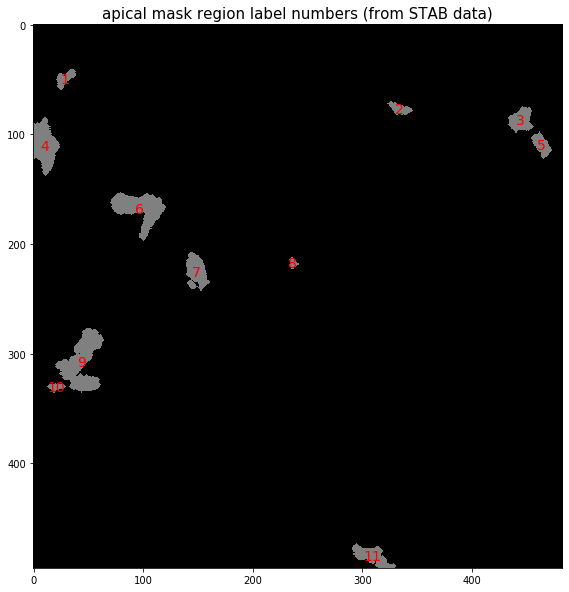

In [29]:
%matplotlib inline

# start with the filtered image...
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = [10, 10])
ax.imshow(Q, norm=None, vmax=2, cmap='gray') # dim the white a bit, easier to see the annnotations
ax.set_title("apical mask region label numbers (from " + image_tags[roi_idx][0] + " data)", fontsize=15)

# annotate each region with its label number 
for props in regionprops(R):
  y, x = props.centroid # get the centroid for each region
  t = ax.text(x, y, str(props.label), ha='center', va='center', size=14, c='r')
fig.savefig(resultsdir + "/" + image_tags[roi_idx][0] + "-apical_mask_annotated.pdf")
plt.show()


#### DIAGNOSTIC: Plot apical region responses for the same stimulation frequency used to generate the mask.


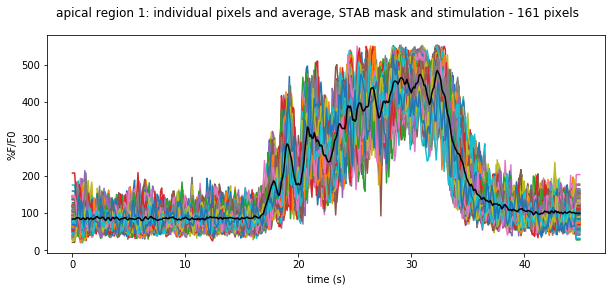

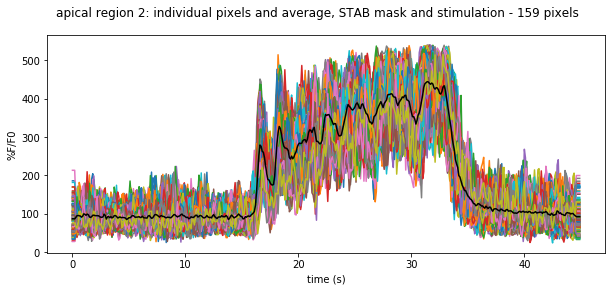

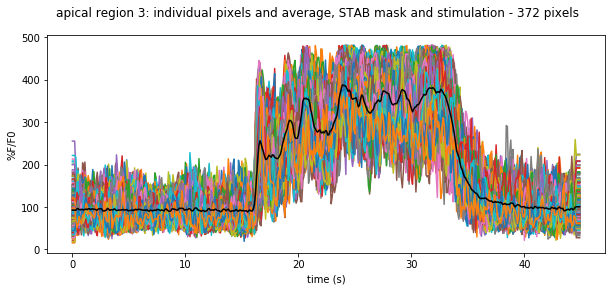

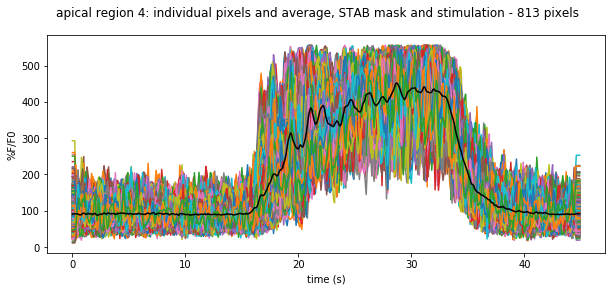

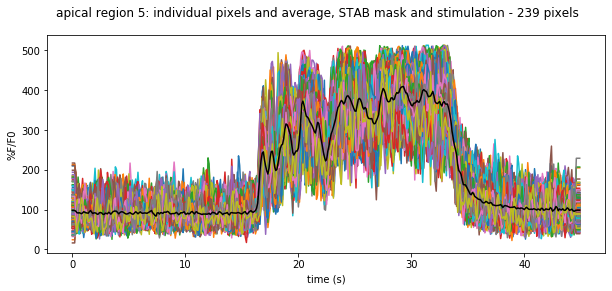

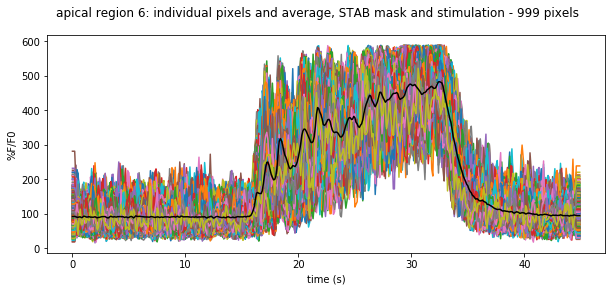

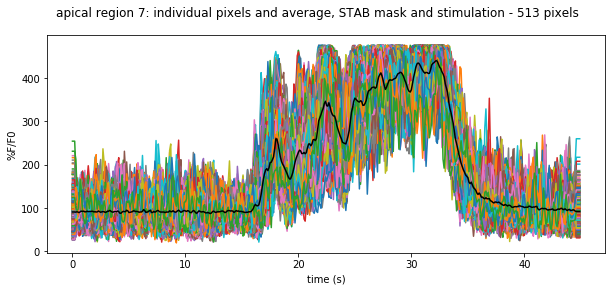

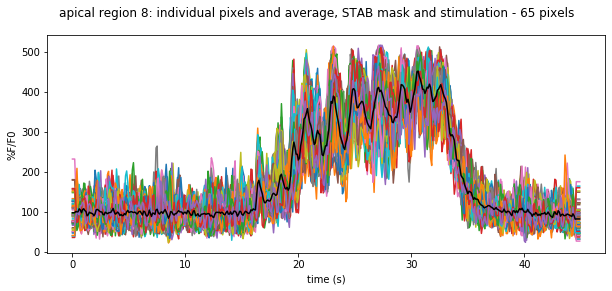

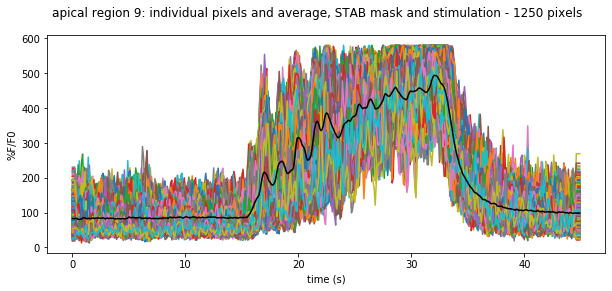

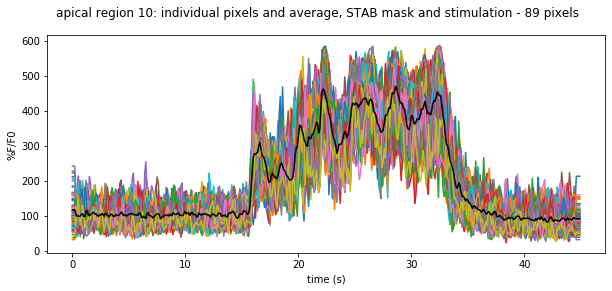

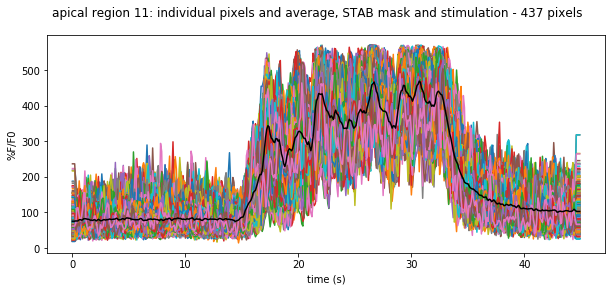

In [30]:
%matplotlib inline

# apical region plots using the mask
X = np.array(range(A0.shape[0])) * (1/image_fps) # the timebase

# create and save plots
for c in ROI:
  if(c==0):
    continue
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize = [10, 4])
  fig.suptitle('apical region ' + str(c)+ ": individual pixels and average, " + image_tags[roi_idx][0] + " mask and stimulation - " +str(COUNT[c]) + " pixels")

  A = np.concatenate((A0[:stim_start-1,:,:], A0[stim_done:,:,:])) # unstimulated only
  M = np.mean(A, axis=0)
  F0 = np.mean(M[R==ROI[c]]) # per region 
  #F0 = M[R==ROI[c]] # per pixel
  S = 100 * A0[:, R==ROI[c]] / F0
  T = np.sum(S, axis=1) / S.shape[1]
  ax.plot(X, S)
  ax.plot(X, T, color='black')
  ax.set(ylabel="%F/F0")
  ax.set(xlabel="time (s)")

  # save figure to pdf
  s = "/apical_region_" + str(c).zfill(2) + "-mask" + image_tags[roi_idx][0] + "-stim" + image_tags[roi_idx][0] + ".pdf"
  fig.savefig(resultsdir + s)
  
  plt.show()
  plt.close() # frees up memory



#### RESULTS: Plot responses for all stimulation frequencies and regions using the mask from above.
#### Save responses to CSV files.
NOTE: The first CSV column is the time base, followed by a column for each stimulation frequency.

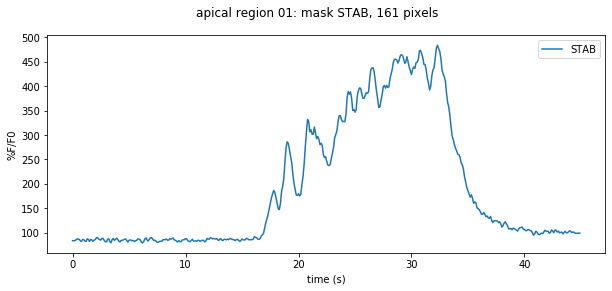

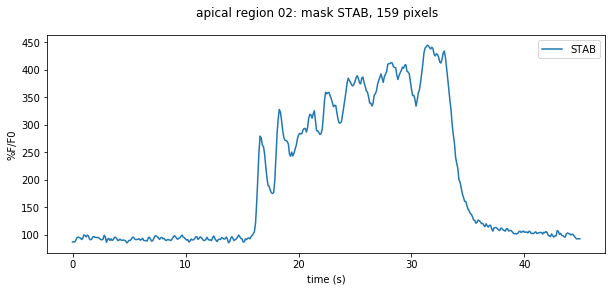

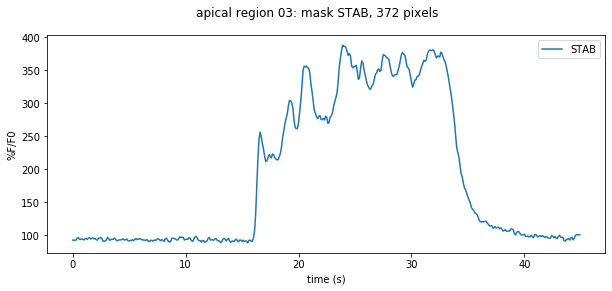

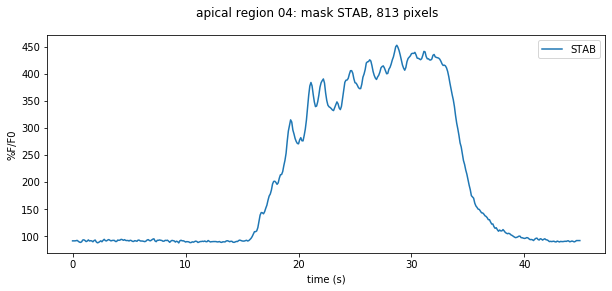

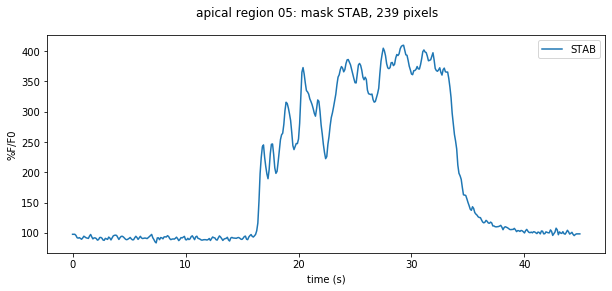

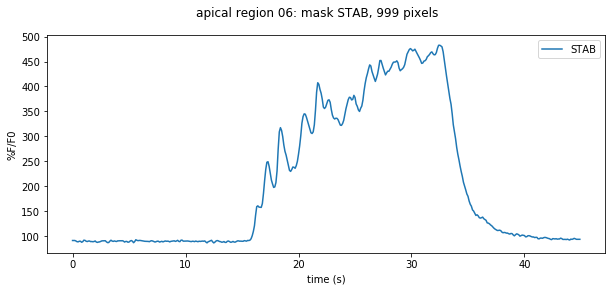

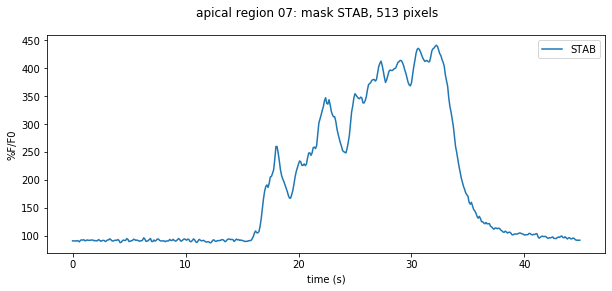

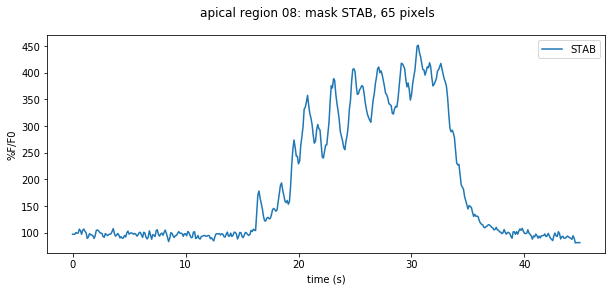

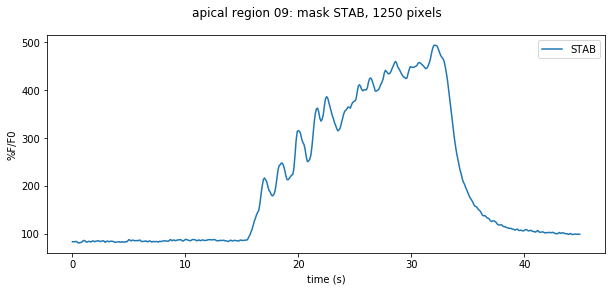

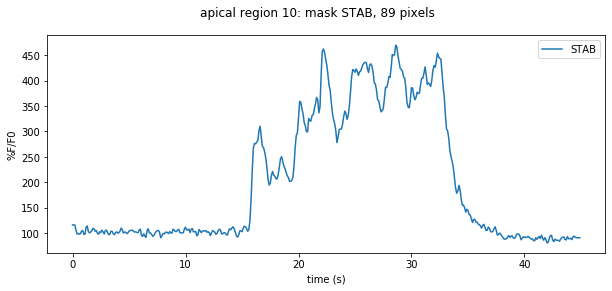

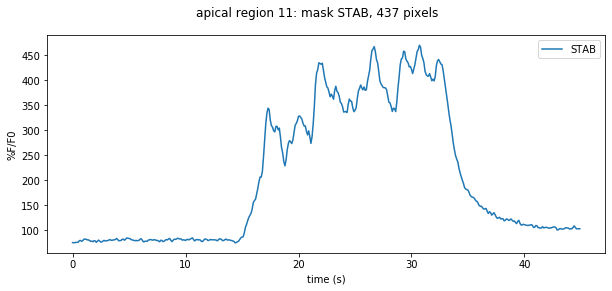

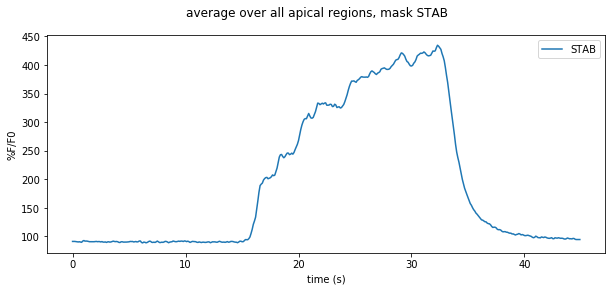

In [31]:
%matplotlib inline

# calculate, plot and save region responses for all stimulation frequencies

# calculate all of the results
RESULTS = np.zeros((len(image_files), ROI.shape[0]-1, A0.shape[0])) # array for all of the apical results
X = np.array(range(RESULTS.shape[2])) * (1/image_fps) # the timebase
for f in image_files:
  # get image stack
  A0x = io.imread("../image_stacks/" + f)
  A0x = np.float32(A0x/(2.0**image_bits))

  # average out y-direction aliasing over every other line
  for n in range(A0x.shape[0] - 1): # moving average over every two lines
    A0x[n] = (A0x[n] + A0x[n+1]) / 2.0

  Ax = np.concatenate((A0x[:stim_start-1,:,:], A0x[stim_done:,:,:])) # unstimulated only
  Mx = np.mean(Ax, axis=0)

  for c in ROI:
    if(c==0):
      continue
    F0 = np.mean(Mx[R==ROI[c]]) # per region 
    S = 100 * A0x[:, R==ROI[c]] / F0
    T = np.sum(S, axis=1) / S.shape[1]
    RESULTS[list(image_files).index(f), c-1] = T # save in the results array

# plot and save responses for all the stimulation frequencies by region
for n in range(1,len(ROI)):
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize = [10, 4])
  fig.suptitle('apical region ' + str(ROI[n]).zfill(2) + ": mask "+ image_tags[roi_idx][0] + ", " + str(COUNT[n]) + " pixels")

  ax.plot(X, np.transpose(RESULTS[:, n-1, :]))
  ax.set(ylabel="%F/F0")
  ax.set(xlabel="time (s)")
  ax.legend([t[0] for t in image_tags][0:len(image_files)])

  # save figure to pdf
  fig.savefig(resultsdir + "/apical_region_" + str(n).zfill(2) + "-mask" + image_tags[roi_idx][0] + "-stimALL.pdf")
    
  plt.show()
  plt.close() # frees up memory

  # save responses to CSV file
  with open (resultsdir + "/apical_region_" + str(n).zfill(2) + "-mask" + image_tags[roi_idx][0] + "-stimALL.csv", 'w') as file:
    writer = csv.writer(file)
    for i in range(RESULTS.shape[2]):
      t = np.append(X[i], RESULTS[:,n-1,i])
      writer.writerow('{:3.3e}'.format(x) for x in t)

# plot average of region responses for all the stimulation frequencies
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = [10, 4])
fig.suptitle("average over all apical regions, mask "+ image_tags[roi_idx][0])

Y = np.transpose(np.sum(RESULTS, axis=(1)))/RESULTS.shape[1]
ax.plot(X, Y)
ax.set(ylabel="%F/F0")
ax.set(xlabel="time (s)")
ax.legend([t[0] for t in image_tags][0:len(image_files)])

# save figure to pdf
fig.savefig(resultsdir + "/apical_region_AVG-mask" + image_tags[roi_idx][0] + "-stimALL.pdf")
    
plt.show()
plt.close() # frees up memory

# save average of responses to CSV file
with open (resultsdir + "/apical_region_AVG-mask" + image_tags[roi_idx][0] + "-stimALL.csv", 'w') as file:
  writer = csv.writer(file)
  for i in range(X.shape[0]):
    t = np.append(X[i], Y[i])
    writer.writerow('{:3.3e}'.format(x) for x in t)

